In [1]:
import os
import time
import pandas as pd
import numpy as np
from random import sample
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from Bio import SeqIO
from multiprocessing import Process

import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CPU device")

GPU device: NVIDIA GeForce RTX 3080 Laptop GPU


# device

In [3]:
dev = 'cuda'
dev2 = 'cpu'

# prep

In [4]:
clade_info = pd.read_csv('clade_info_2.csv',
                         index_col = 0,
                         header = None)
# clade_info

clade = {}

for x in set(clade_info.iloc[:, 0]):
    clade[x] = []

for x in list(clade_info.index):
    clade[clade_info.loc[x, 1]].append(x)

In [5]:
for x in clade.keys():
    print(len(clade[x]))

186
190
190
190
183
188


In [6]:
train_set = []
test_set = []

total_each = 130
for_train = 80

for x in clade.keys():
    to = sample(clade[x], total_each)# 每个类取 个
    train_set.extend(to[0: for_train])# 给训练集 个
    test_set.extend(to[for_train: ])# 给测试集 个
    
print(len(train_set))
print(len(test_set))

480
300


In [7]:
softmax = {'A': [1,0,0,0,0,0], 
           'B1': [0,1,0,0,0,0], 
           'B2': [0,0,1,0,0,0],
           'D': [0,0,0,1,0,0],
           'E': [0,0,0,0,1,0],
           'N9': [0,0,0,0,0,1],}

bo_d = {}

for x in softmax.keys():
    if x == 'B2':
        bo_d[x] = [1]
    else:
        bo_d[x] = [0]

# load

In [8]:
to_stack_x = []
to_stack_y = []

count = 0

for x in train_set:
    path = 'np/'
    
#     to_stack_x.append(torch.tensor(torch.load(path
#                                               + x 
#                                               + '.pt'
#                                              )
#                                   ).to(device = dev)
#                      )
    
    to_stack_x.append(torch.load(path + x + '.pt'
                                ).clone().detach().to(device = dev)
                     )
    
    to_stack_y.append(softmax[clade_info.loc[x, 1]
                              ]
                     )

#     to_stack_y.append(bo_d[clade_info.loc[x, 1]
#                               ]
#                      )
                                               
    
#     print(count)
    count += 1

In [9]:
to_stack_x_test = []
to_stack_y_test = []

count = 0

for x in test_set:
    path = 'np/'
    
    to_stack_x_test.append(torch.load(path + x + '.pt'
                                ).clone().detach().to(device = dev)
                     )
                                               
    to_stack_y_test.append(softmax[clade_info.loc[x, 1]
                                  ]
                     )

#     to_stack_y_test.append(bo_d[clade_info.loc[x, 1]
#                               ]
#                      )
#     print(count)
    count += 1

path = 'np/'

t = torch.from_numpy(np.load(path + '11128.npy')
                    ).type(torch.FloatTensor).to(device = dev)

len(t[0])
t.shape

In [10]:
train_x = torch.stack((to_stack_x))
test_x = torch.stack((to_stack_x_test))

In [11]:
del to_stack_x
del to_stack_x_test

In [12]:
train_x = train_x.reshape(len(train_set), 1, 4, 614129)
test_x = test_x.reshape(len(test_set), 1, 4, 614129)

In [13]:
train_y = torch.FloatTensor(to_stack_y).to(device = dev)
test_y = torch.FloatTensor(to_stack_y_test).to(device = dev)

In [14]:
del to_stack_y
del to_stack_y_test

# model

In [15]:
# ```Python
class the_model(nn.Module):

    def __init__(self):
        super(the_model, self).__init__()
        
#         self.dropout = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = (4, 46),
                               stride = 9
                              ).to(torch.device(dev))
        
        self.mp1 = nn.MaxPool2d(kernel_size = (1, 31), 
                                stride = 5
                               ).to(torch.device(dev)
                                   )
        
        
        self.conv2 = nn.Conv2d(in_channels = 6,
                               out_channels = 1,
                               kernel_size = (1, 6),
#                                stride = 1
                              ).to(torch.device(dev))
        
        self.mp2 = nn.MaxPool2d(kernel_size = (1, 10),
                    stride = 2).to(torch.device(dev))
        
        
        self.conv3 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
                                   
        self.mp3 = nn.MaxPool2d(kernel_size = (1, 20),
                                stride = 5).to(torch.device(dev)
                                              )
                                   
        self.conv4 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
        self.mp4 = nn.MaxPool2d(kernel_size = (1, 30),
                                stride = 10).to(torch.device(dev)
                                               )
        
        self.fc1 = nn.Linear(133, 
                             6
                            ).to(torch.device(dev)
                                )
        
#         self.fc2 = nn.Linear(in_features = 1000, 
#                              out_features = 6
#                             ).to(torch.device(dev)
#                                 )
        
    def forward(self, x):
        
        x = self.conv1(x)
#         x = self.dropout(x)
        x = self.mp1(x)
        
        x = self.conv2(x)
#         x = self.dropout(x)
        x = self.mp2(x)
        
        x = self.conv3(x)
#         x = self.dropout(x)
        x = self.mp3(x)
                                   
        x = self.conv4(x)
#         x = self.dropout(x)
        x = self.mp4(x)
        
        x = torch.flatten(x, 1)
#         x = self.dropout(x)
        
        x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
        
#         x = self.bo(x)
        
        return x
# ```

In [16]:
net = the_model()

In [17]:
loss_function = nn.CrossEntropyLoss().to(torch.device(dev))
# loss_function = nn.MSELoss().to(torch.device(dev))
# loss_function = nn.BCELoss().to(torch.device(dev))
optimizer = torch.optim.Adam(net.parameters(), 
                             lr = 8e-3,
                             weight_decay = 0 # 3e-2 
                            )

In [18]:
m1 = nn.Sigmoid()
m2 = nn.Softmax(dim = 1)

In [19]:
print(len(train_set))
print(len(test_set))

480
300


0
Fri Feb 10 12:41:10 2023
train loss: 1.7936865091323853
test loss: 1.7937175035476685
predict right count in train: tensor(82, device='cuda:0')
predict right count in test: tensor(51, device='cuda:0')


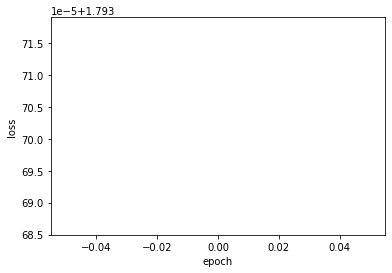

1
Fri Feb 10 12:41:15 2023
train loss: 1.792242169380188
test loss: 1.7922321557998657
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


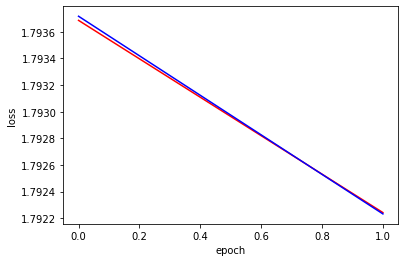

2
Fri Feb 10 12:41:15 2023
train loss: 1.7920736074447632
test loss: 1.7920634746551514
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


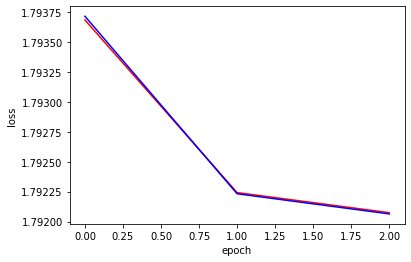

3
Fri Feb 10 12:41:15 2023
train loss: 1.7918201684951782
test loss: 1.7918435335159302
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


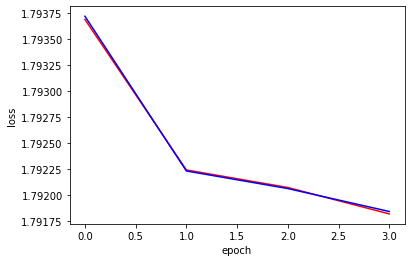

4
Fri Feb 10 12:41:15 2023
train loss: 1.7915561199188232
test loss: 1.791542649269104
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


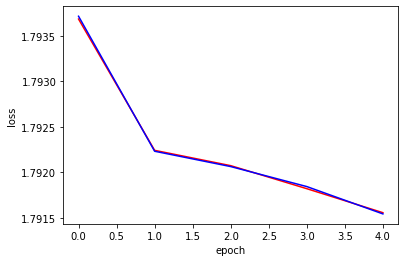

5
Fri Feb 10 12:41:16 2023
train loss: 1.7920461893081665
test loss: 1.7920758724212646
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


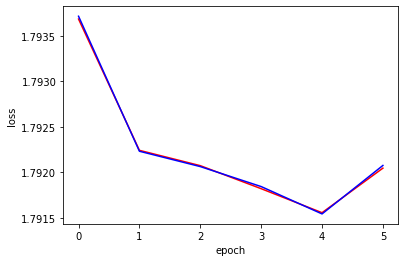

6
Fri Feb 10 12:41:16 2023
train loss: 1.7912477254867554
test loss: 1.7912594079971313
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


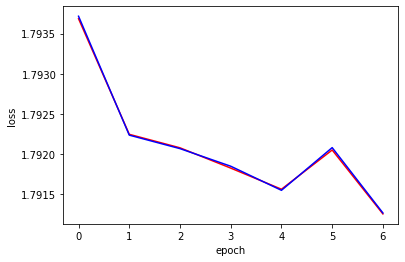

7
Fri Feb 10 12:41:16 2023
train loss: 1.7907456159591675
test loss: 1.7907429933547974
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


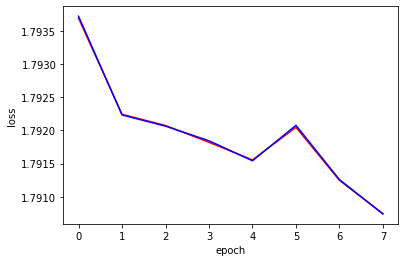

8
Fri Feb 10 12:41:17 2023
train loss: 1.7902828454971313
test loss: 1.7902857065200806
predict right count in train: tensor(122, device='cuda:0')
predict right count in test: tensor(73, device='cuda:0')


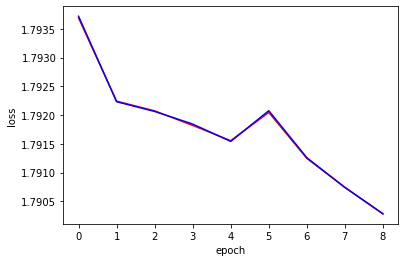

9
Fri Feb 10 12:41:17 2023
train loss: 1.7895104885101318
test loss: 1.789544701576233
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


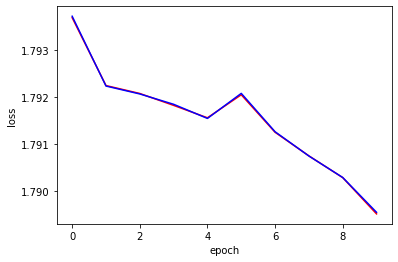

10
Fri Feb 10 12:41:17 2023
train loss: 1.7885981798171997
test loss: 1.7886360883712769
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


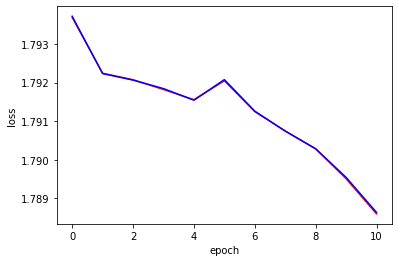

11
Fri Feb 10 12:41:17 2023
train loss: 1.787451982498169
test loss: 1.787483811378479
predict right count in train: tensor(86, device='cuda:0')
predict right count in test: tensor(51, device='cuda:0')


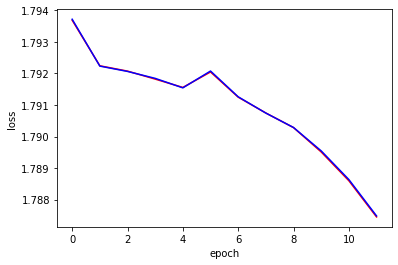

12
Fri Feb 10 12:41:17 2023
train loss: 1.7858068943023682
test loss: 1.785849690437317
predict right count in train: tensor(148, device='cuda:0')
predict right count in test: tensor(96, device='cuda:0')


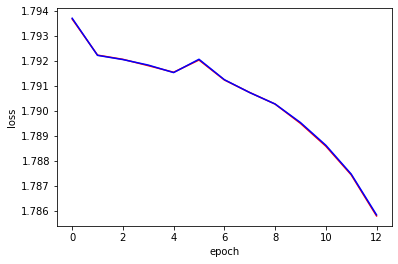

13
Fri Feb 10 12:41:18 2023
train loss: 1.7830713987350464
test loss: 1.7830764055252075
predict right count in train: tensor(154, device='cuda:0')
predict right count in test: tensor(98, device='cuda:0')


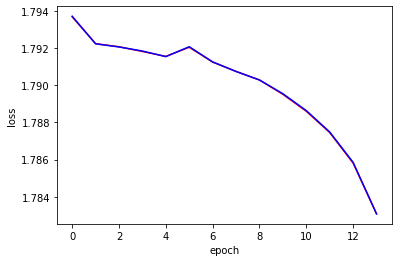

14
Fri Feb 10 12:41:18 2023
train loss: 1.7829152345657349
test loss: 1.7828996181488037
predict right count in train: tensor(106, device='cuda:0')
predict right count in test: tensor(66, device='cuda:0')


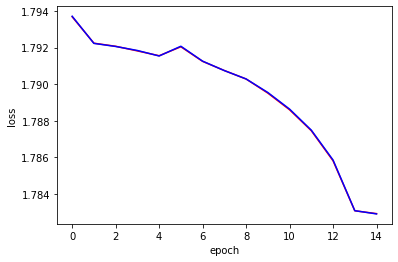

15
Fri Feb 10 12:41:18 2023
train loss: 1.7769838571548462
test loss: 1.7769179344177246
predict right count in train: tensor(230, device='cuda:0')
predict right count in test: tensor(146, device='cuda:0')


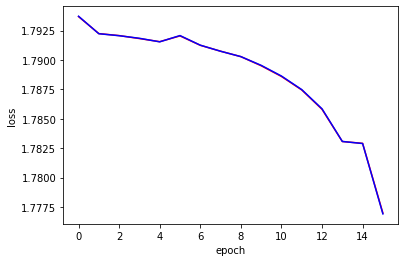

16
Fri Feb 10 12:41:18 2023
train loss: 1.7727010250091553
test loss: 1.7726479768753052
predict right count in train: tensor(287, device='cuda:0')
predict right count in test: tensor(179, device='cuda:0')


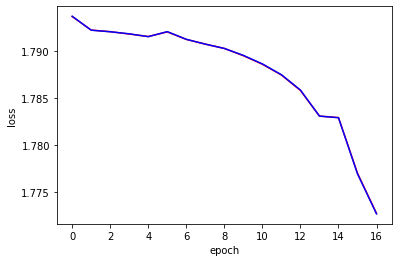

17
Fri Feb 10 12:41:19 2023
train loss: 1.7657687664031982
test loss: 1.765774130821228
predict right count in train: tensor(297, device='cuda:0')
predict right count in test: tensor(189, device='cuda:0')


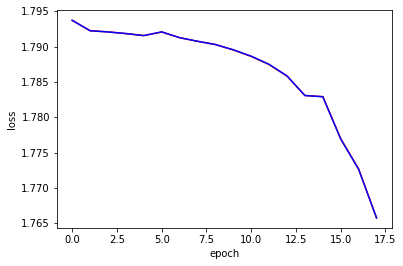

18
Fri Feb 10 12:41:19 2023
train loss: 1.7598693370819092
test loss: 1.759940266609192
predict right count in train: tensor(353, device='cuda:0')
predict right count in test: tensor(218, device='cuda:0')


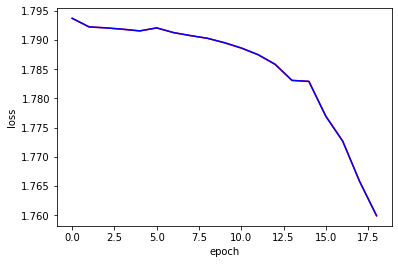

19
Fri Feb 10 12:41:19 2023
train loss: 1.7485705614089966
test loss: 1.7486470937728882
predict right count in train: tensor(281, device='cuda:0')
predict right count in test: tensor(174, device='cuda:0')


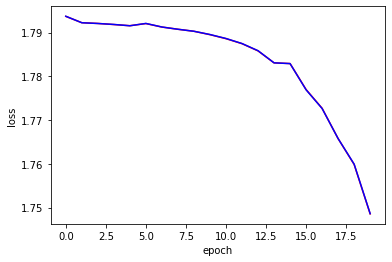

20
Fri Feb 10 12:41:19 2023
train loss: 1.7357821464538574
test loss: 1.7359154224395752
predict right count in train: tensor(232, device='cuda:0')
predict right count in test: tensor(141, device='cuda:0')


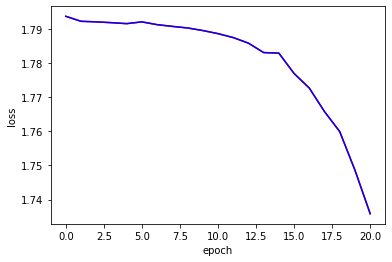

21
Fri Feb 10 12:41:20 2023
train loss: 1.7215855121612549
test loss: 1.7218176126480103
predict right count in train: tensor(319, device='cuda:0')
predict right count in test: tensor(196, device='cuda:0')


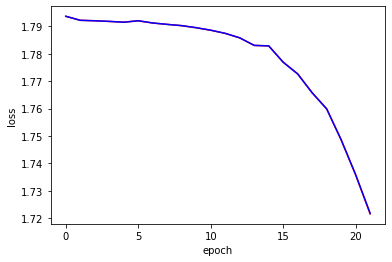

22
Fri Feb 10 12:41:20 2023
train loss: 1.6999483108520508
test loss: 1.700361967086792
predict right count in train: tensor(379, device='cuda:0')
predict right count in test: tensor(237, device='cuda:0')


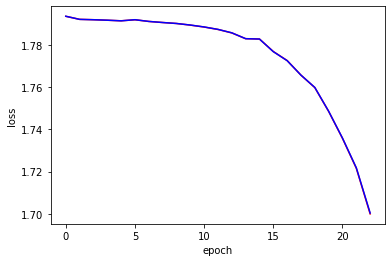

23
Fri Feb 10 12:41:20 2023
train loss: 1.685287356376648
test loss: 1.6855571269989014
predict right count in train: tensor(233, device='cuda:0')
predict right count in test: tensor(145, device='cuda:0')


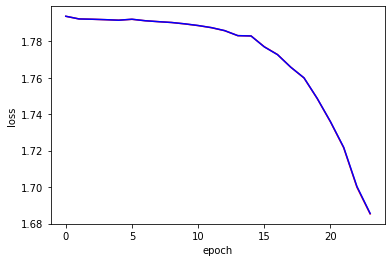

24
Fri Feb 10 12:41:20 2023
train loss: 1.6558765172958374
test loss: 1.6566423177719116
predict right count in train: tensor(313, device='cuda:0')
predict right count in test: tensor(193, device='cuda:0')


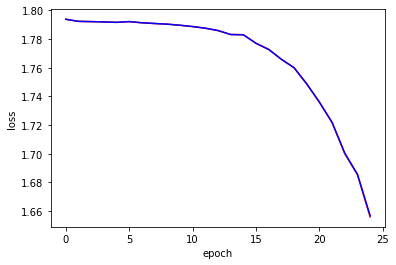

25
Fri Feb 10 12:41:20 2023
train loss: 1.6207884550094604
test loss: 1.6213377714157104
predict right count in train: tensor(348, device='cuda:0')
predict right count in test: tensor(219, device='cuda:0')


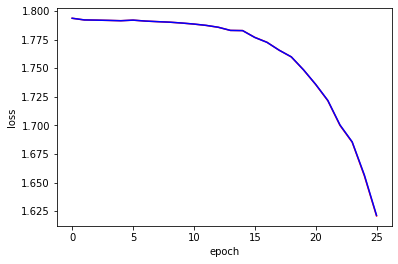

26
Fri Feb 10 12:41:21 2023
train loss: 1.595515489578247
test loss: 1.5961928367614746
predict right count in train: tensor(426, device='cuda:0')
predict right count in test: tensor(262, device='cuda:0')


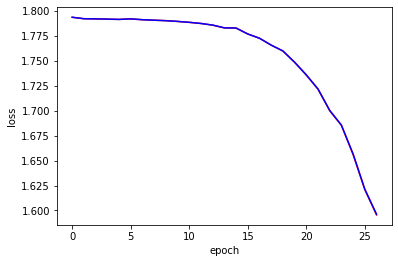

27
Fri Feb 10 12:41:21 2023
train loss: 1.5366863012313843
test loss: 1.537667989730835
predict right count in train: tensor(466, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


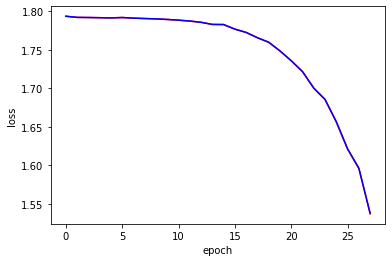

28
Fri Feb 10 12:41:21 2023
train loss: 1.4983081817626953
test loss: 1.4988394975662231
predict right count in train: tensor(312, device='cuda:0')
predict right count in test: tensor(195, device='cuda:0')


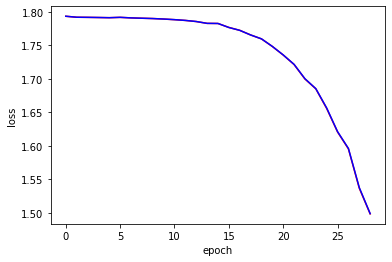

29
Fri Feb 10 12:41:21 2023
train loss: 1.4428887367248535
test loss: 1.444130301475525
predict right count in train: tensor(454, device='cuda:0')
predict right count in test: tensor(280, device='cuda:0')


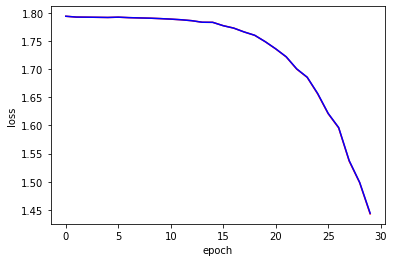

30
Fri Feb 10 12:41:22 2023
train loss: 1.3726354837417603
test loss: 1.3746813535690308
predict right count in train: tensor(455, device='cuda:0')
predict right count in test: tensor(280, device='cuda:0')


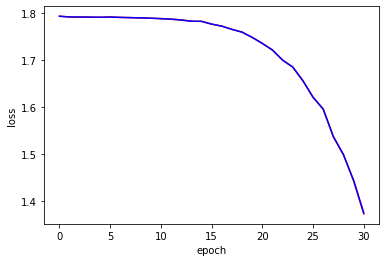

31
Fri Feb 10 12:41:22 2023
train loss: 1.298019528388977
test loss: 1.3008732795715332
predict right count in train: tensor(449, device='cuda:0')
predict right count in test: tensor(284, device='cuda:0')


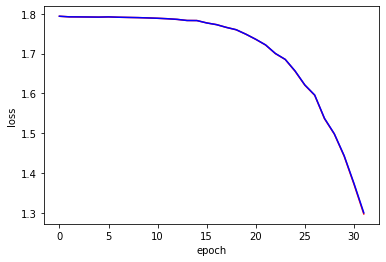

32
Fri Feb 10 12:41:22 2023
train loss: 1.213714361190796
test loss: 1.2178856134414673
predict right count in train: tensor(459, device='cuda:0')
predict right count in test: tensor(284, device='cuda:0')


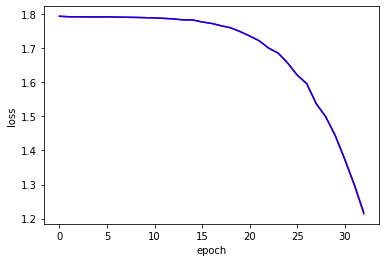

33
Fri Feb 10 12:41:22 2023
train loss: 1.1316879987716675
test loss: 1.1362156867980957
predict right count in train: tensor(467, device='cuda:0')
predict right count in test: tensor(288, device='cuda:0')


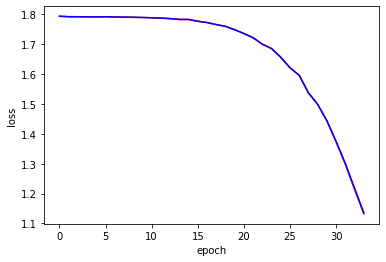

34
Fri Feb 10 12:41:23 2023
train loss: 1.0267632007598877
test loss: 1.0327107906341553
predict right count in train: tensor(468, device='cuda:0')
predict right count in test: tensor(286, device='cuda:0')


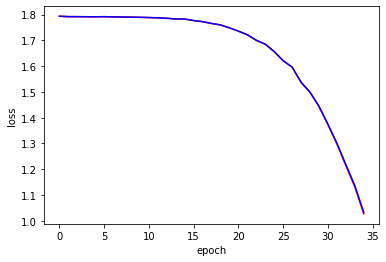

35
Fri Feb 10 12:41:23 2023
train loss: 0.9178611040115356
test loss: 0.9252429604530334
predict right count in train: tensor(461, device='cuda:0')
predict right count in test: tensor(283, device='cuda:0')


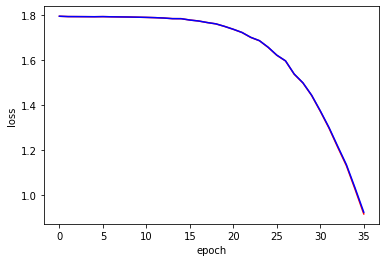

36
Fri Feb 10 12:41:23 2023
train loss: 0.827500581741333
test loss: 0.836109459400177
predict right count in train: tensor(460, device='cuda:0')
predict right count in test: tensor(283, device='cuda:0')


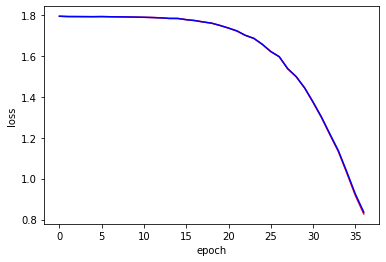

37
Fri Feb 10 12:41:23 2023
train loss: 0.7136094570159912
test loss: 0.7258581519126892
predict right count in train: tensor(465, device='cuda:0')
predict right count in test: tensor(286, device='cuda:0')


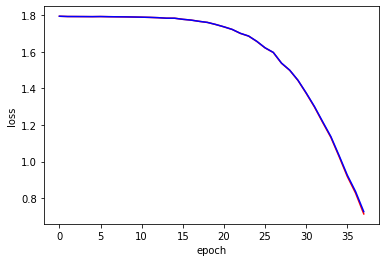

38
Fri Feb 10 12:41:23 2023
train loss: 0.613608181476593
test loss: 0.6265692114830017
predict right count in train: tensor(466, device='cuda:0')
predict right count in test: tensor(286, device='cuda:0')


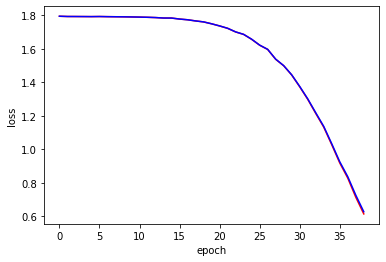

39
Fri Feb 10 12:41:24 2023
train loss: 0.514778733253479
test loss: 0.5307926535606384
predict right count in train: tensor(462, device='cuda:0')
predict right count in test: tensor(285, device='cuda:0')


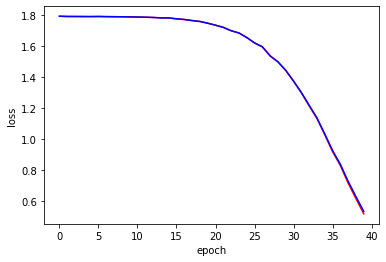

40
Fri Feb 10 12:41:24 2023
train loss: 0.426074355840683
test loss: 0.4487608075141907
predict right count in train: tensor(461, device='cuda:0')
predict right count in test: tensor(284, device='cuda:0')


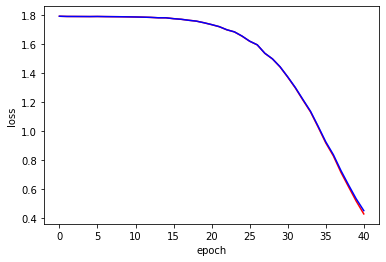

41
Fri Feb 10 12:41:24 2023
train loss: 0.3539993464946747
test loss: 0.3824114501476288
predict right count in train: tensor(469, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


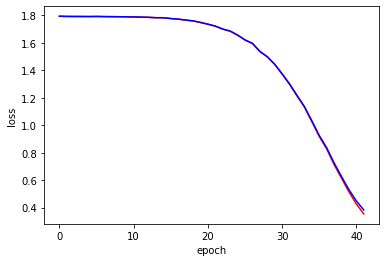

42
Fri Feb 10 12:41:24 2023
train loss: 0.2840491831302643
test loss: 0.31544387340545654
predict right count in train: tensor(463, device='cuda:0')
predict right count in test: tensor(285, device='cuda:0')


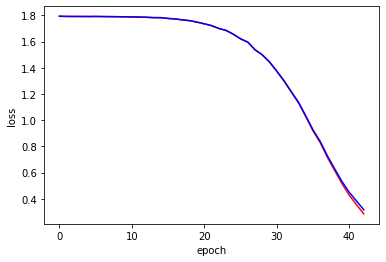

43
Fri Feb 10 12:41:25 2023
train loss: 0.2333851307630539
test loss: 0.26981619000434875
predict right count in train: tensor(464, device='cuda:0')
predict right count in test: tensor(285, device='cuda:0')


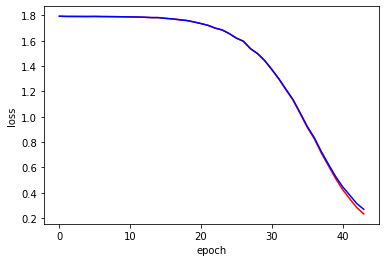

44
Fri Feb 10 12:41:25 2023
train loss: 0.18874432146549225
test loss: 0.23388667404651642
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


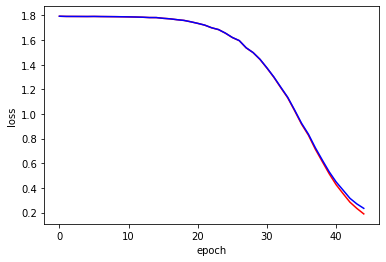

45
Fri Feb 10 12:41:25 2023
train loss: 0.15428458154201508
test loss: 0.2074274867773056
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


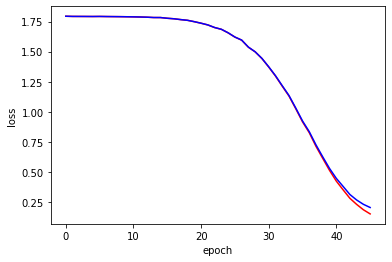

46
Fri Feb 10 12:41:25 2023
train loss: 0.12730132043361664
test loss: 0.1856193095445633
predict right count in train: tensor(468, device='cuda:0')
predict right count in test: tensor(288, device='cuda:0')


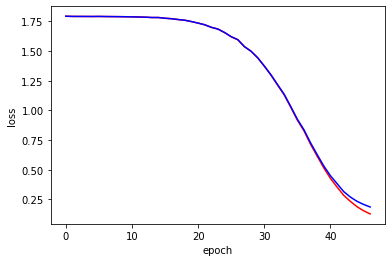

47
Fri Feb 10 12:41:26 2023
train loss: 0.10612436383962631
test loss: 0.1639740914106369
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


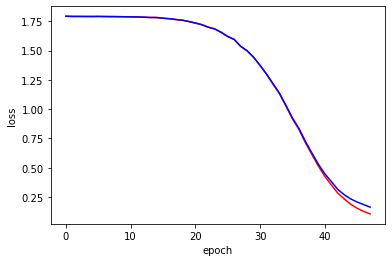

48
Fri Feb 10 12:41:26 2023
train loss: 0.08972597122192383
test loss: 0.16131789982318878
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


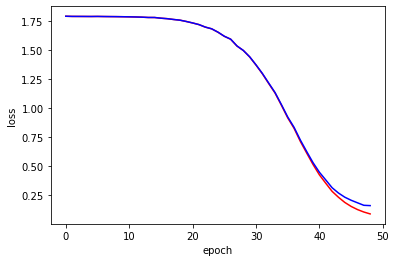

49
Fri Feb 10 12:41:26 2023
train loss: 0.07888036966323853
test loss: 0.16257652640342712
predict right count in train: tensor(470, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


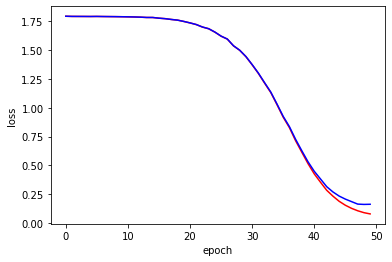

50
Fri Feb 10 12:41:26 2023
train loss: 0.06828910112380981
test loss: 0.14929689466953278
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


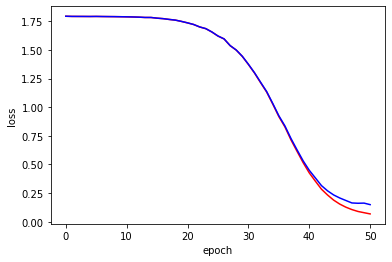

51
Fri Feb 10 12:41:27 2023
train loss: 0.061935778707265854
test loss: 0.14321236312389374
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


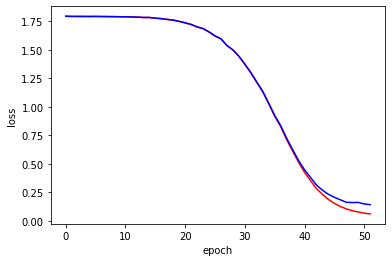

52
Fri Feb 10 12:41:27 2023
train loss: 0.055524978786706924
test loss: 0.1504475474357605
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


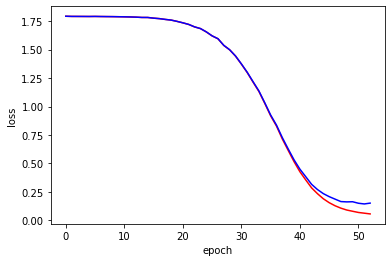

53
Fri Feb 10 12:41:27 2023
train loss: 0.05113906040787697
test loss: 0.1540212333202362
predict right count in train: tensor(472, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


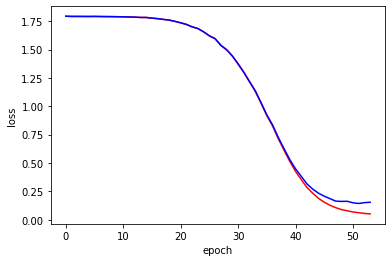

54
Fri Feb 10 12:41:27 2023
train loss: 0.0475461483001709
test loss: 0.14846764504909515
predict right count in train: tensor(472, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


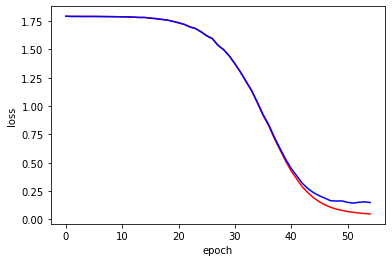

55
Fri Feb 10 12:41:27 2023
train loss: 0.045365747064352036
test loss: 0.14680181443691254
predict right count in train: tensor(474, device='cuda:0')
predict right count in test: tensor(290, device='cuda:0')


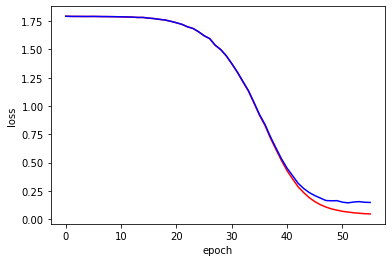

56
Fri Feb 10 12:41:28 2023
train loss: 0.0426296703517437
test loss: 0.14408767223358154
predict right count in train: tensor(472, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


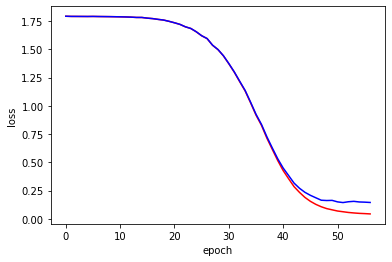

57
Fri Feb 10 12:41:28 2023
train loss: 0.04078427329659462
test loss: 0.14566920697689056
predict right count in train: tensor(472, device='cuda:0')
predict right count in test: tensor(288, device='cuda:0')


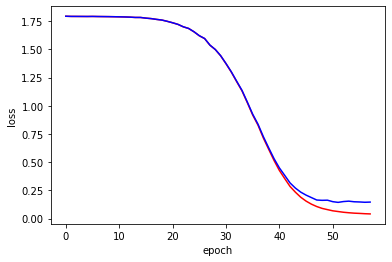

58
Fri Feb 10 12:41:28 2023
train loss: 0.03891747444868088
test loss: 0.1524609476327896
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


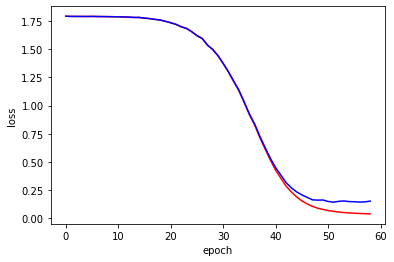

59
Fri Feb 10 12:41:28 2023
train loss: 0.036843471229076385
test loss: 0.15018314123153687
predict right count in train: tensor(475, device='cuda:0')
predict right count in test: tensor(290, device='cuda:0')


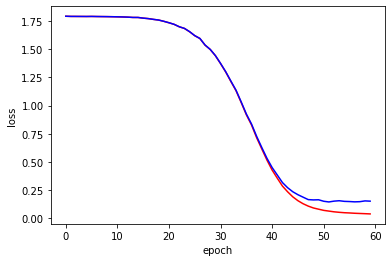

60
Fri Feb 10 12:41:29 2023
train loss: 0.035274043679237366
test loss: 0.14759278297424316
predict right count in train: tensor(473, device='cuda:0')
predict right count in test: tensor(290, device='cuda:0')


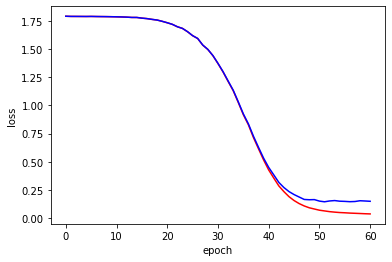

61
Fri Feb 10 12:41:29 2023
train loss: 0.03348342701792717
test loss: 0.15401527285575867
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(291, device='cuda:0')


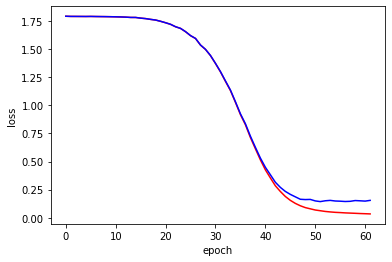

62
Fri Feb 10 12:41:29 2023
train loss: 0.03148605674505234
test loss: 0.15625187754631042
predict right count in train: tensor(477, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


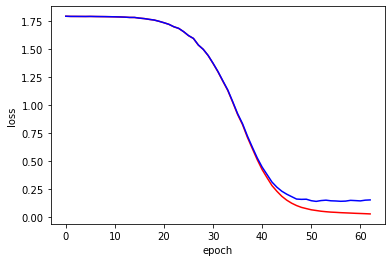

63
Fri Feb 10 12:41:29 2023
train loss: 0.03014948219060898
test loss: 0.15631960332393646
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


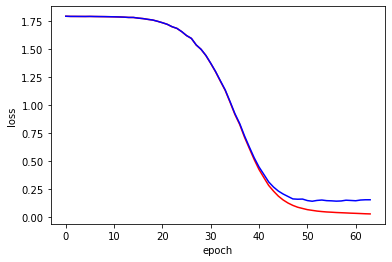

64
Fri Feb 10 12:41:30 2023
train loss: 0.028538737446069717
test loss: 0.16160063445568085
predict right count in train: tensor(477, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


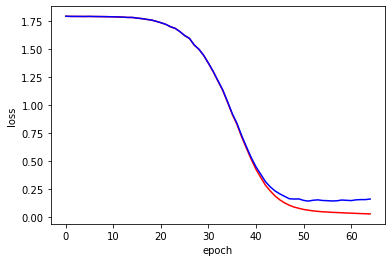

65
Fri Feb 10 12:41:30 2023
train loss: 0.026972072198987007
test loss: 0.16108697652816772
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


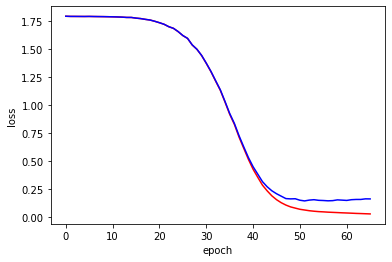

66
Fri Feb 10 12:41:30 2023
train loss: 0.02540186047554016
test loss: 0.15223728120326996
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


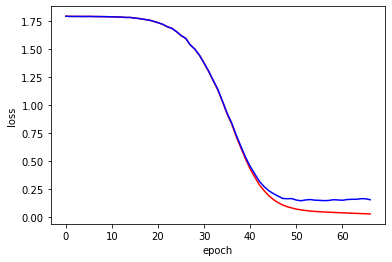

67
Fri Feb 10 12:41:30 2023
train loss: 0.02427240088582039
test loss: 0.14722061157226562
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


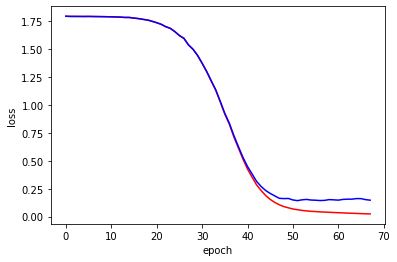

68
Fri Feb 10 12:41:30 2023
train loss: 0.022968212142586708
test loss: 0.14695380628108978
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


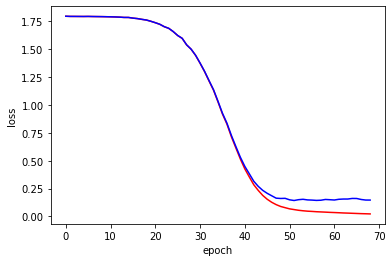

69
Fri Feb 10 12:41:31 2023
train loss: 0.022048331797122955
test loss: 0.14747531712055206
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


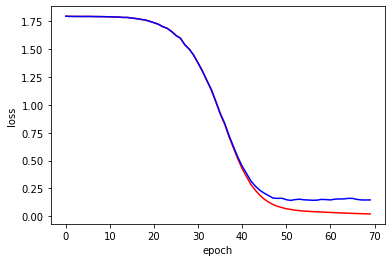

70
Fri Feb 10 12:41:31 2023
train loss: 0.021249057725071907
test loss: 0.1461300551891327
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


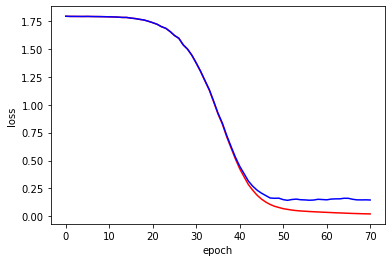

71
Fri Feb 10 12:41:31 2023
train loss: 0.020533084869384766
test loss: 0.141611710190773
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


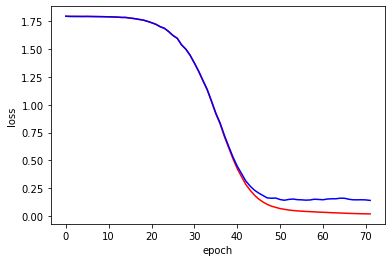

72
Fri Feb 10 12:41:31 2023
train loss: 0.019811047241091728
test loss: 0.13713017106056213
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


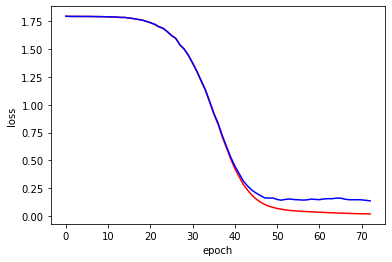

73
Fri Feb 10 12:41:32 2023
train loss: 0.019228748977184296
test loss: 0.13493038713932037
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


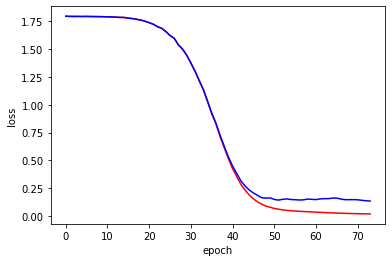

74
Fri Feb 10 12:41:32 2023
train loss: 0.018621321767568588
test loss: 0.1356651335954666
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


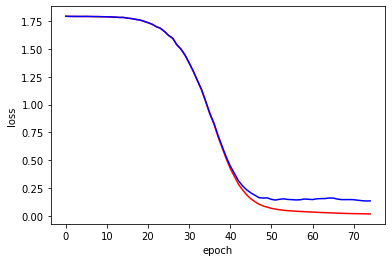

75
Fri Feb 10 12:41:32 2023
train loss: 0.018062295392155647
test loss: 0.13664983212947845
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


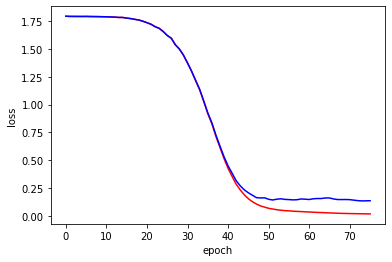

76
Fri Feb 10 12:41:32 2023
train loss: 0.01744917407631874
test loss: 0.13264481723308563
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


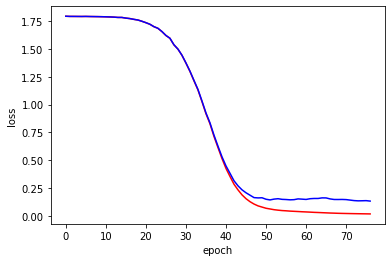

77
Fri Feb 10 12:41:33 2023
train loss: 0.016979698091745377
test loss: 0.12882724404335022
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


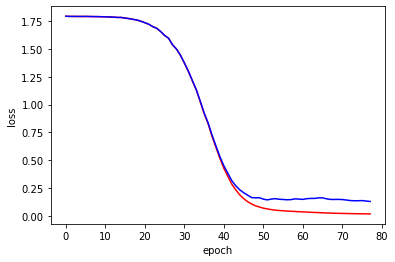

78
Fri Feb 10 12:41:33 2023
train loss: 0.01653933711349964
test loss: 0.12808245420455933
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


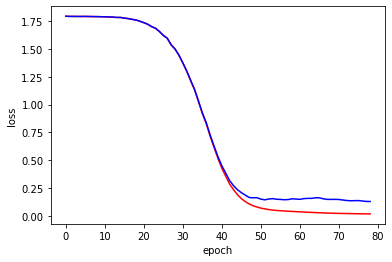

79
Fri Feb 10 12:41:33 2023
train loss: 0.016110636293888092
test loss: 0.12879590690135956
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


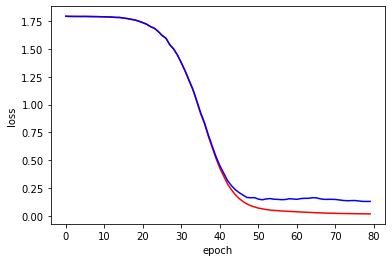

80
Fri Feb 10 12:41:33 2023
train loss: 0.015731722116470337
test loss: 0.13224661350250244
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


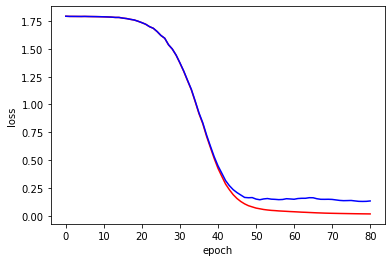

81
Fri Feb 10 12:41:34 2023
train loss: 0.01534833014011383
test loss: 0.13210360705852509
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


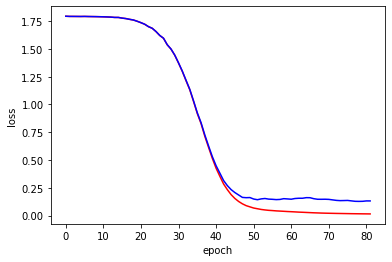

82
Fri Feb 10 12:41:34 2023
train loss: 0.014999021776020527
test loss: 0.1320338398218155
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


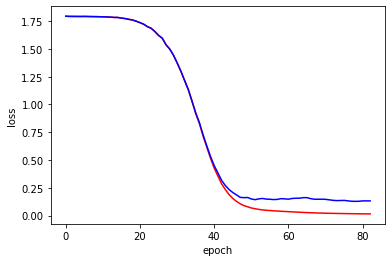

83
Fri Feb 10 12:41:34 2023
train loss: 0.014652647078037262
test loss: 0.13270823657512665
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


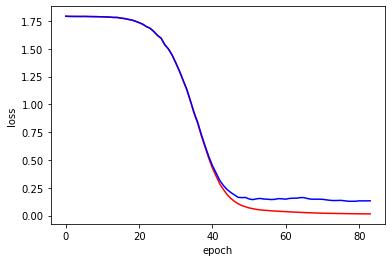

84
Fri Feb 10 12:41:34 2023
train loss: 0.014334945939481258
test loss: 0.13288253545761108
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


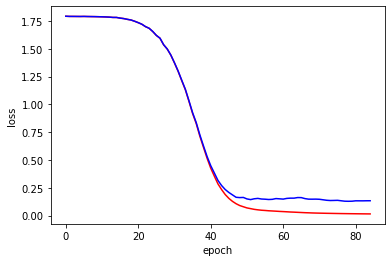

85
Fri Feb 10 12:41:35 2023
train loss: 0.014043099246919155
test loss: 0.13577952980995178
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


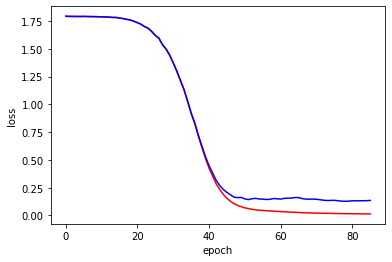

86
Fri Feb 10 12:41:35 2023
train loss: 0.01373963337391615
test loss: 0.1364506483078003
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


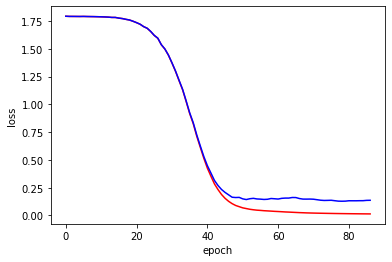

87
Fri Feb 10 12:41:35 2023
train loss: 0.013465987518429756
test loss: 0.138019397854805
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


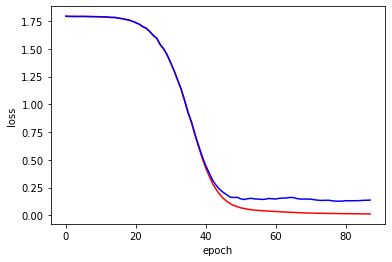

88
Fri Feb 10 12:41:35 2023
train loss: 0.013182505965232849
test loss: 0.1386580467224121
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


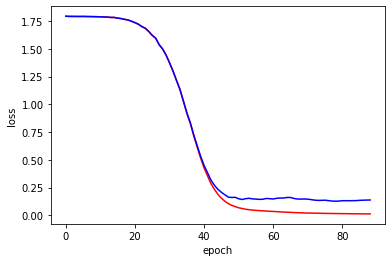

89
Fri Feb 10 12:41:36 2023
train loss: 0.012908199802041054
test loss: 0.13857832551002502
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


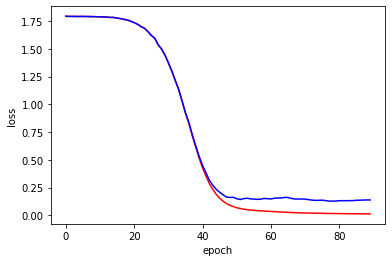

90
Fri Feb 10 12:41:36 2023
train loss: 0.012651626951992512
test loss: 0.1393246203660965
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


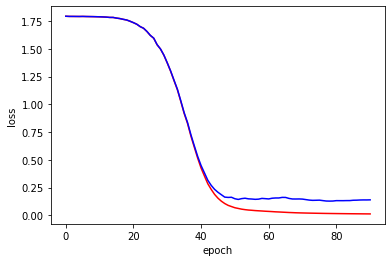

91
Fri Feb 10 12:41:36 2023
train loss: 0.012408128008246422
test loss: 0.13809208571910858
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


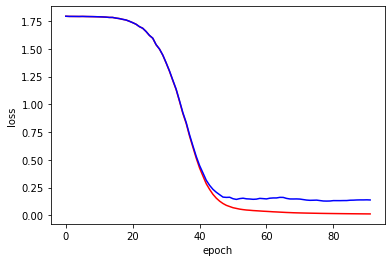

92
Fri Feb 10 12:41:36 2023
train loss: 0.012246490456163883
test loss: 0.1402706503868103
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


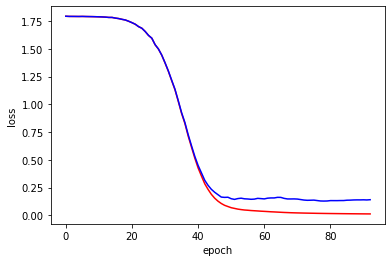

93
Fri Feb 10 12:41:37 2023
train loss: 0.012269885279238224
test loss: 0.13816381990909576
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


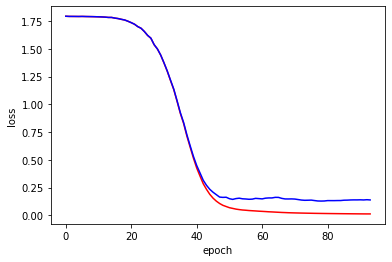

94
Fri Feb 10 12:41:37 2023
train loss: 0.013149461708962917
test loss: 0.14570945501327515
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


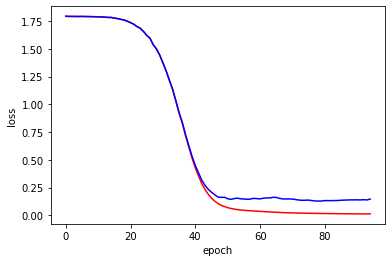

95
Fri Feb 10 12:41:37 2023
train loss: 0.015969175845384598
test loss: 0.13833245635032654
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


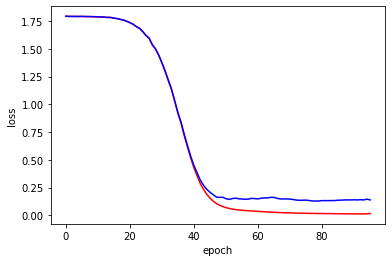

96
Fri Feb 10 12:41:37 2023
train loss: 0.028193453326821327
test loss: 0.1697838455438614
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(295, device='cuda:0')


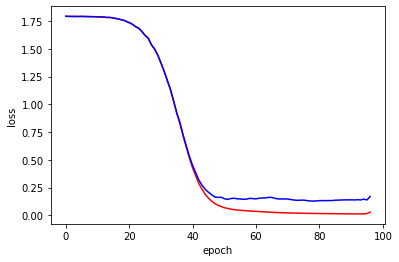

97
Fri Feb 10 12:41:37 2023
train loss: 0.060075923800468445
test loss: 0.16359925270080566
predict right count in train: tensor(470, device='cuda:0')
predict right count in test: tensor(286, device='cuda:0')


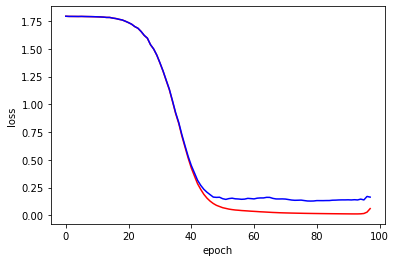

98
Fri Feb 10 12:41:38 2023
train loss: 0.06027001887559891
test loss: 0.2165367156267166
predict right count in train: tensor(474, device='cuda:0')
predict right count in test: tensor(290, device='cuda:0')


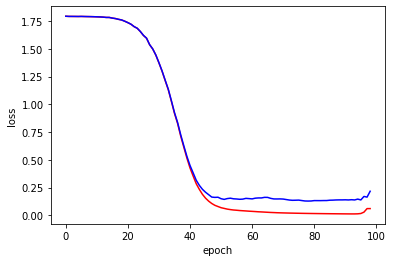

99
Fri Feb 10 12:41:38 2023
train loss: 0.020506219938397408
test loss: 0.11402392387390137
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


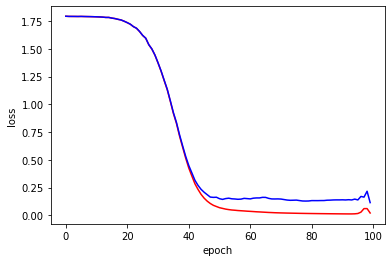

100
Fri Feb 10 12:41:38 2023
train loss: 0.04030338302254677
test loss: 0.09746333211660385
predict right count in train: tensor(474, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


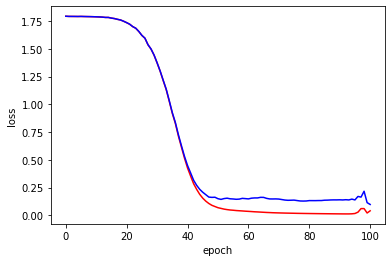

101
Fri Feb 10 12:41:38 2023
train loss: 0.016081873327493668
test loss: 0.13369685411453247
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


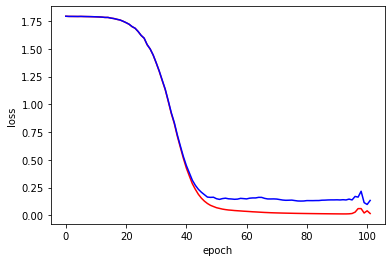

102
Fri Feb 10 12:41:39 2023
train loss: 0.033219240605831146
test loss: 0.18279291689395905
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


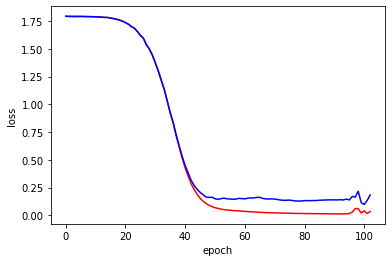

103
Fri Feb 10 12:41:39 2023
train loss: 0.02511676959693432
test loss: 0.14096133410930634
predict right count in train: tensor(472, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


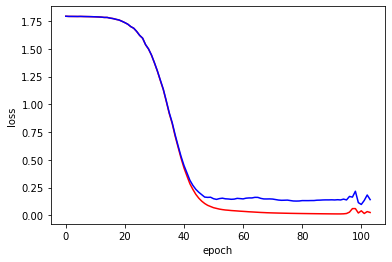

104
Fri Feb 10 12:41:39 2023
train loss: 0.025901542976498604
test loss: 0.11780065298080444
predict right count in train: tensor(474, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


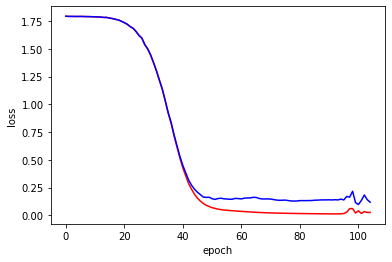

105
Fri Feb 10 12:41:39 2023
train loss: 0.026397865265607834
test loss: 0.1421876698732376
predict right count in train: tensor(477, device='cuda:0')
predict right count in test: tensor(295, device='cuda:0')


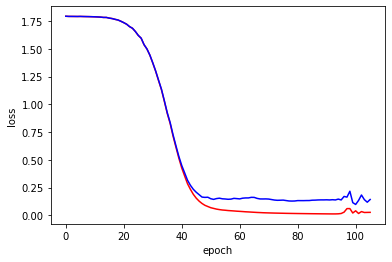

106
Fri Feb 10 12:41:39 2023
train loss: 0.017263250425457954
test loss: 0.1632091999053955
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


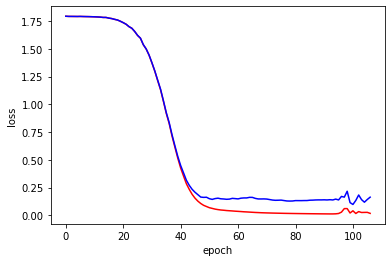

107
Fri Feb 10 12:41:40 2023
train loss: 0.0199937392026186
test loss: 0.1924462616443634
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(291, device='cuda:0')


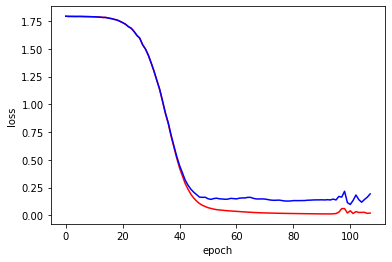

108
Fri Feb 10 12:41:40 2023
train loss: 0.02218412421643734
test loss: 0.19810976088047028
predict right count in train: tensor(477, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


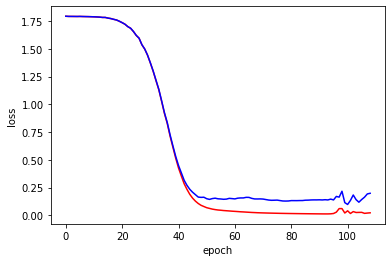

109
Fri Feb 10 12:41:40 2023
train loss: 0.016209345310926437
test loss: 0.189107745885849
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


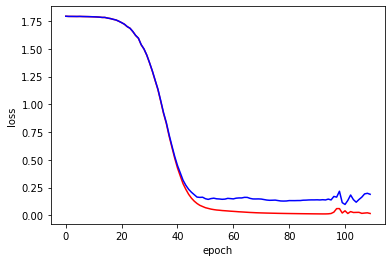

110
Fri Feb 10 12:41:40 2023
train loss: 0.01629607193171978
test loss: 0.18296289443969727
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


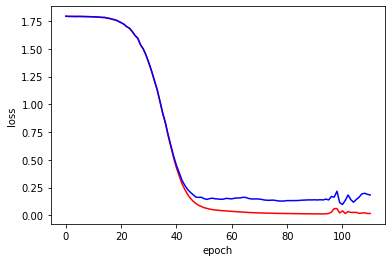

111
Fri Feb 10 12:41:41 2023
train loss: 0.019741063937544823
test loss: 0.17063632607460022
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


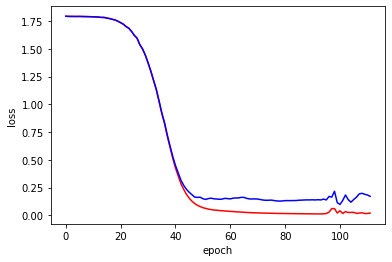

112
Fri Feb 10 12:41:41 2023
train loss: 0.01782344840466976
test loss: 0.14846649765968323
predict right count in train: tensor(477, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


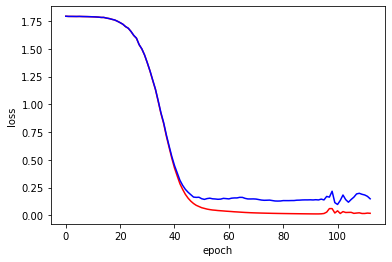

113
Fri Feb 10 12:41:41 2023
train loss: 0.01528260763734579
test loss: 0.13999295234680176
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


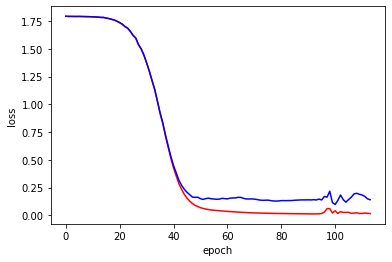

114
Fri Feb 10 12:41:41 2023
train loss: 0.012617725878953934
test loss: 0.15107904374599457
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


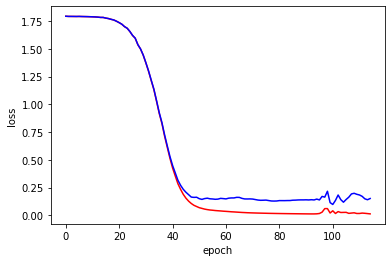

115
Fri Feb 10 12:41:42 2023
train loss: 0.013398935087025166
test loss: 0.16831067204475403
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


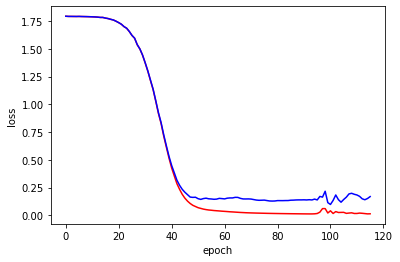

116
Fri Feb 10 12:41:42 2023
train loss: 0.014380117878317833
test loss: 0.17503635585308075
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


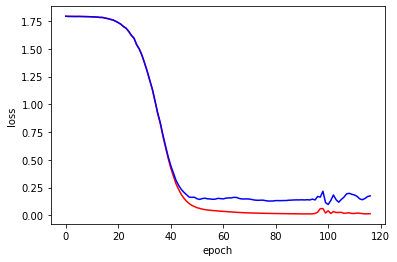

117
Fri Feb 10 12:41:42 2023
train loss: 0.01157394889742136
test loss: 0.15953508019447327
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


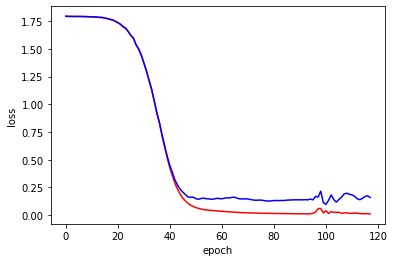

118
Fri Feb 10 12:41:42 2023
train loss: 0.011565139517188072
test loss: 0.14568552374839783
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


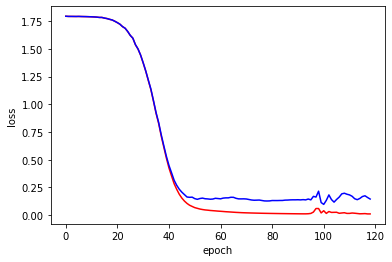

119
Fri Feb 10 12:41:43 2023
train loss: 0.0127794174477458
test loss: 0.1432344913482666
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


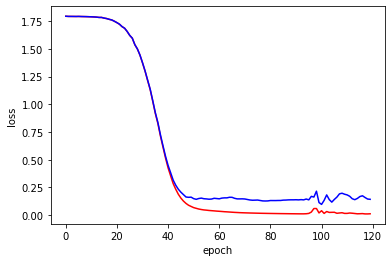

120
Fri Feb 10 12:41:43 2023
train loss: 0.012052404694259167
test loss: 0.15278540551662445
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


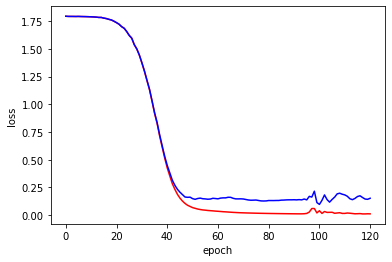

121
Fri Feb 10 12:41:43 2023
train loss: 0.010763606056571007
test loss: 0.17078101634979248
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


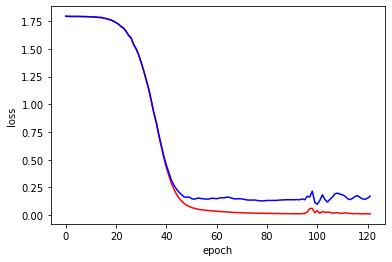

122
Fri Feb 10 12:41:43 2023
train loss: 0.011095019988715649
test loss: 0.18846918642520905
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


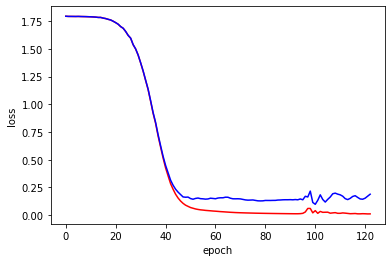

123
Fri Feb 10 12:41:44 2023
train loss: 0.010671804659068584
test loss: 0.18755044043064117
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


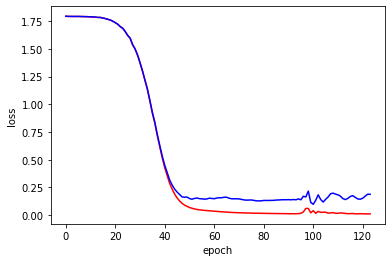

124
Fri Feb 10 12:41:44 2023
train loss: 0.00969519279897213
test loss: 0.1707489788532257
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(293, device='cuda:0')


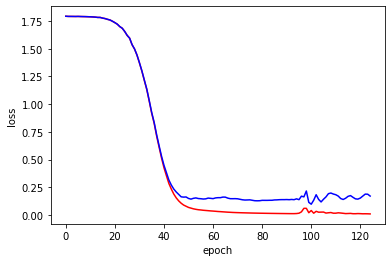

125
Fri Feb 10 12:41:44 2023
train loss: 0.009531404823064804
test loss: 0.15401019155979156
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


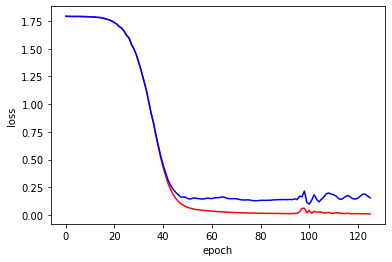

126
Fri Feb 10 12:41:44 2023
train loss: 0.009723699651658535
test loss: 0.1454687863588333
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


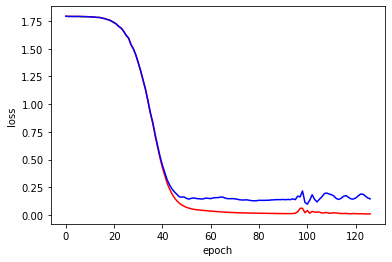

127
Fri Feb 10 12:41:44 2023
train loss: 0.009712481871247292
test loss: 0.14567236602306366
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


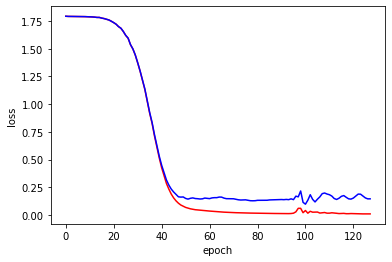

128
Fri Feb 10 12:41:45 2023
train loss: 0.00924533512443304
test loss: 0.15158145129680634
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


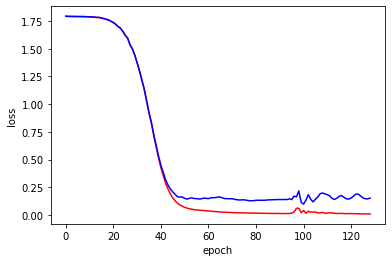

129
Fri Feb 10 12:41:45 2023
train loss: 0.009082319214940071
test loss: 0.16005852818489075
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


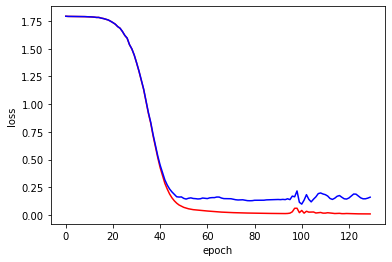

130
Fri Feb 10 12:41:45 2023
train loss: 0.008818346075713634
test loss: 0.16704139113426208
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


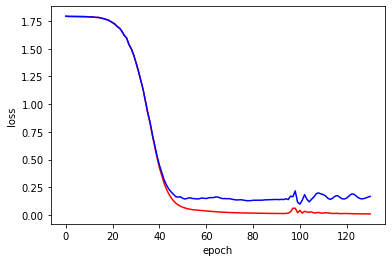

131
Fri Feb 10 12:41:45 2023
train loss: 0.0084357475861907
test loss: 0.16953745484352112
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


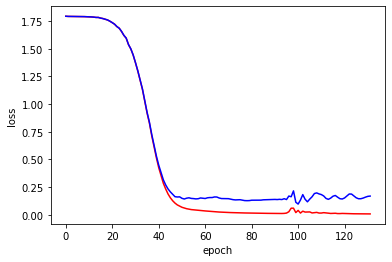

132
Fri Feb 10 12:41:46 2023
train loss: 0.008269058540463448
test loss: 0.16662833094596863
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


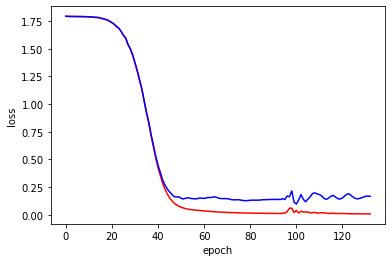

133
Fri Feb 10 12:41:46 2023
train loss: 0.008075409568846226
test loss: 0.16077283024787903
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


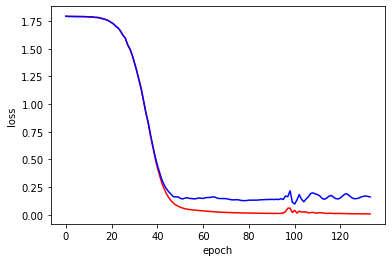

134
Fri Feb 10 12:41:46 2023
train loss: 0.007992921397089958
test loss: 0.15756383538246155
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


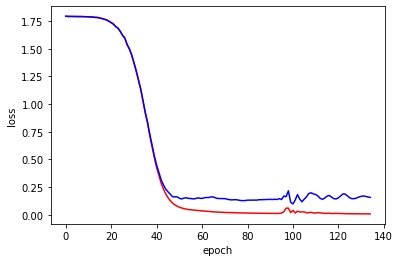

135
Fri Feb 10 12:41:46 2023
train loss: 0.007687147706747055
test loss: 0.15902480483055115
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


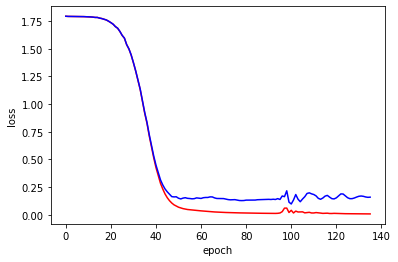

136
Fri Feb 10 12:41:47 2023
train loss: 0.0075044650584459305
test loss: 0.16286061704158783
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


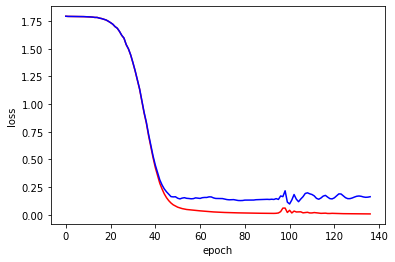

137
Fri Feb 10 12:41:47 2023
train loss: 0.007344942539930344
test loss: 0.16475315392017365
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


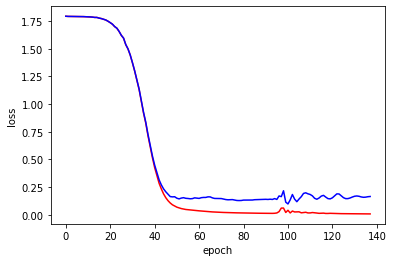

138
Fri Feb 10 12:41:47 2023
train loss: 0.007307991851121187
test loss: 0.1646306961774826
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


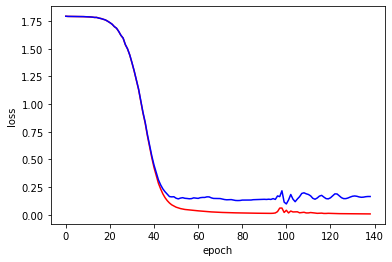

139
Fri Feb 10 12:41:47 2023
train loss: 0.007148329168558121
test loss: 0.1628943532705307
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


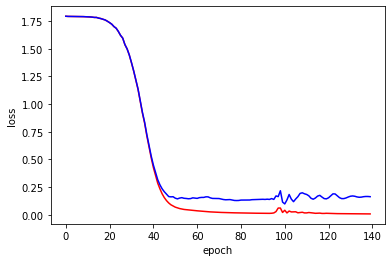

140
Fri Feb 10 12:41:48 2023
train loss: 0.006902501452714205
test loss: 0.15982425212860107
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


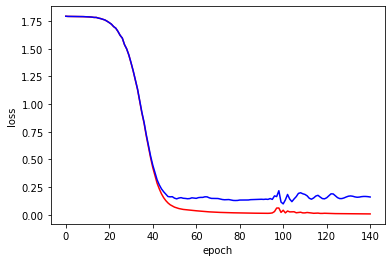

141
Fri Feb 10 12:41:48 2023
train loss: 0.006781351752579212
test loss: 0.157142773270607
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


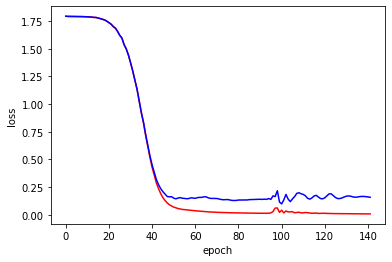

142
Fri Feb 10 12:41:48 2023
train loss: 0.006664476357400417
test loss: 0.15493784844875336
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


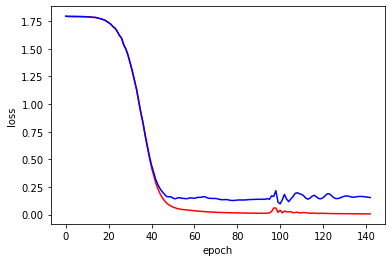

143
Fri Feb 10 12:41:48 2023
train loss: 0.0065757110714912415
test loss: 0.15486177802085876
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


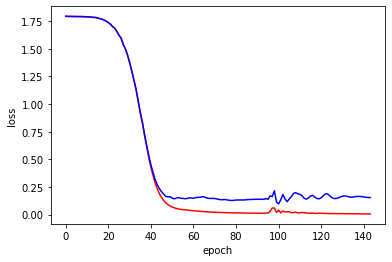

144
Fri Feb 10 12:41:48 2023
train loss: 0.00640465272590518
test loss: 0.157914400100708
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


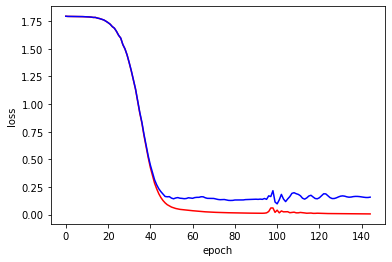

145
Fri Feb 10 12:41:49 2023
train loss: 0.006310260854661465
test loss: 0.16216857731342316
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


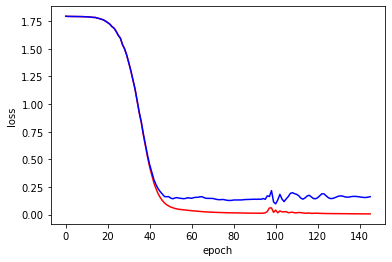

146
Fri Feb 10 12:41:49 2023
train loss: 0.00619702460244298
test loss: 0.16483673453330994
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


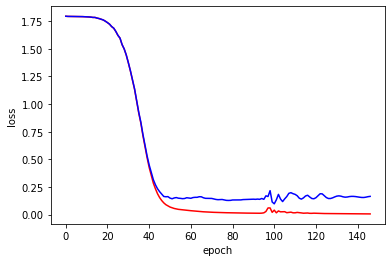

147
Fri Feb 10 12:41:49 2023
train loss: 0.006068182643502951
test loss: 0.16469308733940125
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


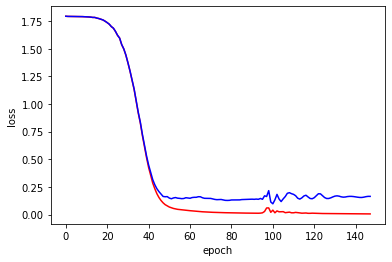

148
Fri Feb 10 12:41:49 2023
train loss: 0.005922817625105381
test loss: 0.1627521514892578
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


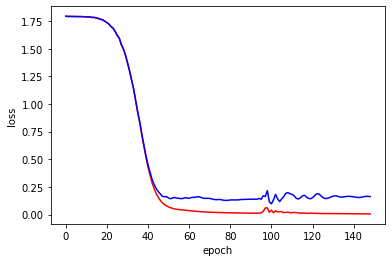

149
Fri Feb 10 12:41:50 2023
train loss: 0.005833227187395096
test loss: 0.16056762635707855
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


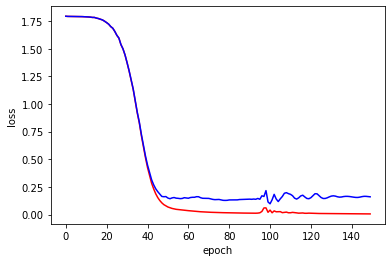

150
Fri Feb 10 12:41:50 2023
train loss: 0.0057630701921880245
test loss: 0.1586025357246399
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


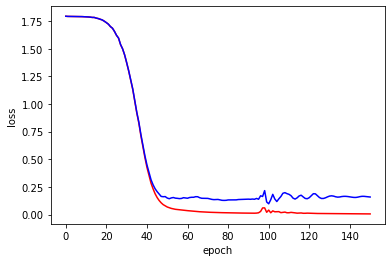

151
Fri Feb 10 12:41:50 2023
train loss: 0.005645613186061382
test loss: 0.15746183693408966
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


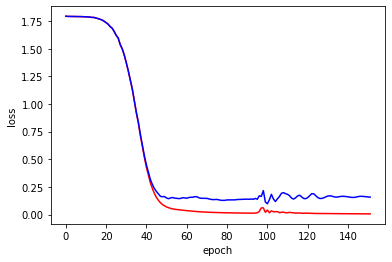

152
Fri Feb 10 12:41:50 2023
train loss: 0.005528234876692295
test loss: 0.15804661810398102
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


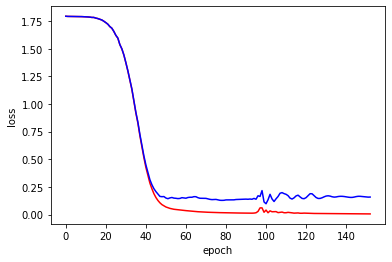

153
Fri Feb 10 12:41:51 2023
train loss: 0.005386461038142443
test loss: 0.16031567752361298
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


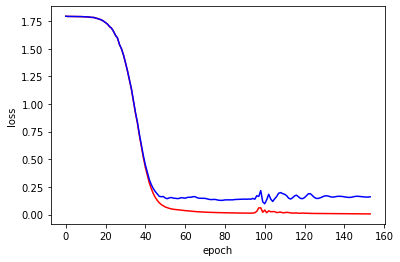

154
Fri Feb 10 12:41:51 2023
train loss: 0.005276890937238932
test loss: 0.16302764415740967
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


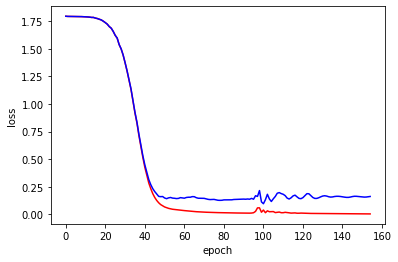

155
Fri Feb 10 12:41:51 2023
train loss: 0.005181850399821997
test loss: 0.16456910967826843
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


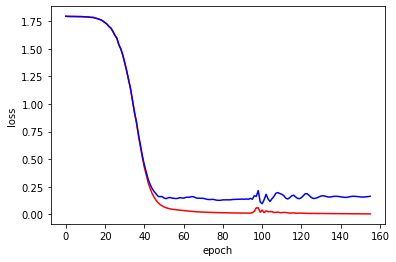

156
Fri Feb 10 12:41:51 2023
train loss: 0.005089073441922665
test loss: 0.1639648973941803
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


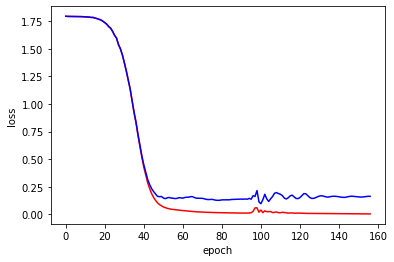

157
Fri Feb 10 12:41:52 2023
train loss: 0.004996898118406534
test loss: 0.16258099675178528
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


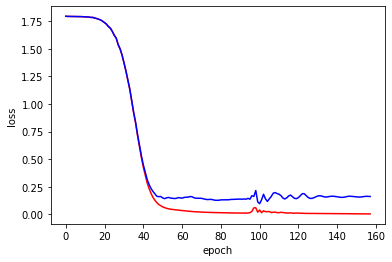

158
Fri Feb 10 12:41:52 2023
train loss: 0.004905709531158209
test loss: 0.16114380955696106
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


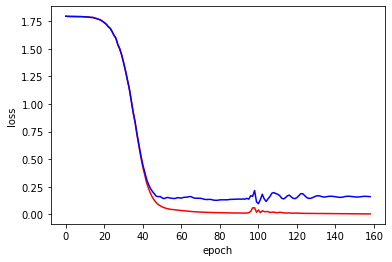

159
Fri Feb 10 12:41:52 2023
train loss: 0.004823554307222366
test loss: 0.15933287143707275
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


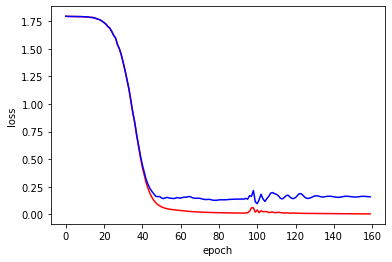

160
Fri Feb 10 12:41:52 2023
train loss: 0.004740795586258173
test loss: 0.1581953912973404
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


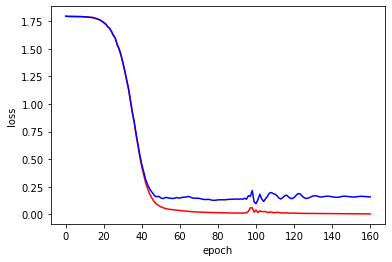

161
Fri Feb 10 12:41:53 2023
train loss: 0.004657265730202198
test loss: 0.15817558765411377
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


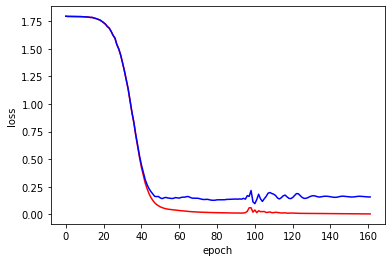

162
Fri Feb 10 12:41:53 2023
train loss: 0.004570212680846453
test loss: 0.15940023958683014
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


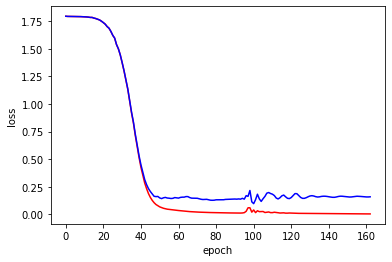

163
Fri Feb 10 12:41:53 2023
train loss: 0.004492541309446096
test loss: 0.1612638384103775
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


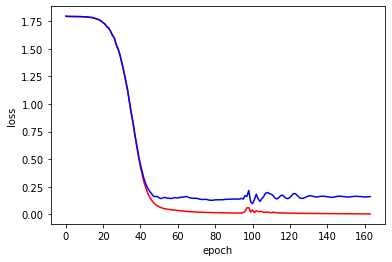

164
Fri Feb 10 12:41:53 2023
train loss: 0.00441350881010294
test loss: 0.16302475333213806
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


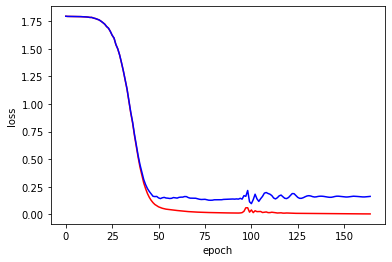

165
Fri Feb 10 12:41:53 2023
train loss: 0.004343406762927771
test loss: 0.16401121020317078
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


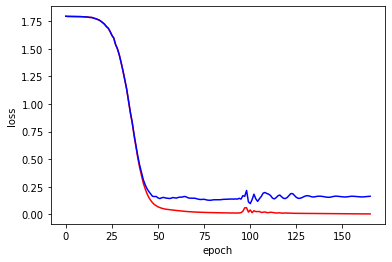

166
Fri Feb 10 12:41:54 2023
train loss: 0.00425923615694046
test loss: 0.1640552133321762
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


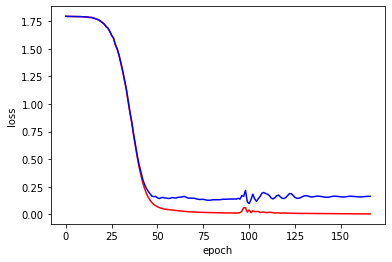

167
Fri Feb 10 12:41:54 2023
train loss: 0.004183543846011162
test loss: 0.16381382942199707
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


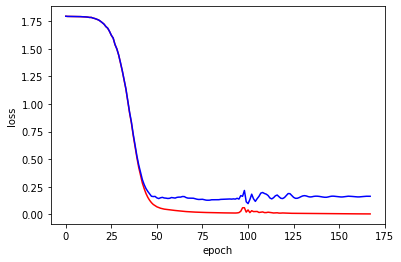

168
Fri Feb 10 12:41:54 2023
train loss: 0.004113091621547937
test loss: 0.1635892242193222
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


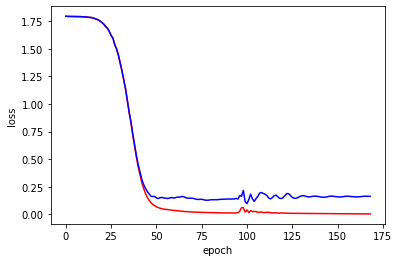

169
Fri Feb 10 12:41:54 2023
train loss: 0.004043384455144405
test loss: 0.1634800285100937
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


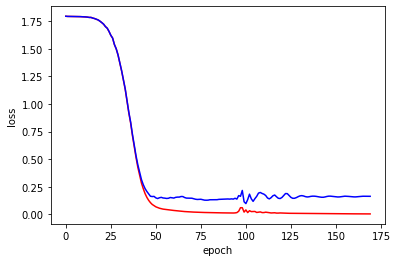

170
Fri Feb 10 12:41:55 2023
train loss: 0.003990891855210066
test loss: 0.16371722519397736
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


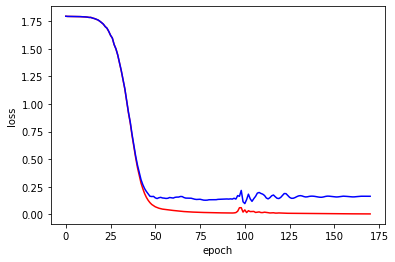

171
Fri Feb 10 12:41:55 2023
train loss: 0.003910272382199764
test loss: 0.16403228044509888
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


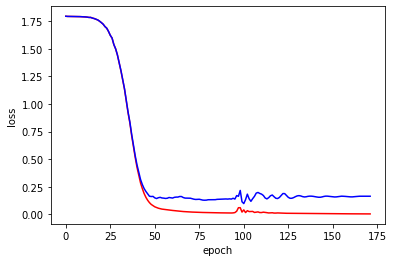

172
Fri Feb 10 12:41:55 2023
train loss: 0.0038528339937329292
test loss: 0.164214625954628
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


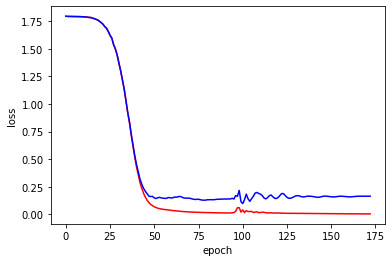

173
Fri Feb 10 12:41:55 2023
train loss: 0.003796272212639451
test loss: 0.1647472083568573
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


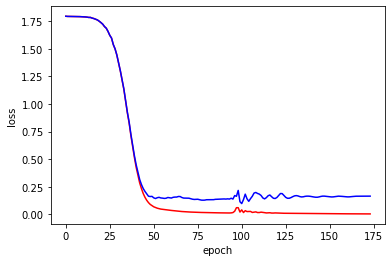

174
Fri Feb 10 12:41:56 2023
train loss: 0.003741767257452011
test loss: 0.16540345549583435
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


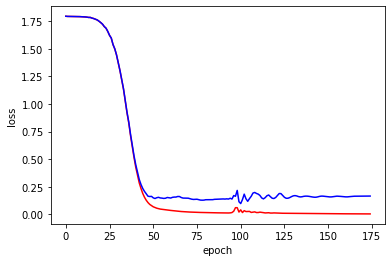

175
Fri Feb 10 12:41:56 2023
train loss: 0.0036736666224896908
test loss: 0.1657741367816925
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


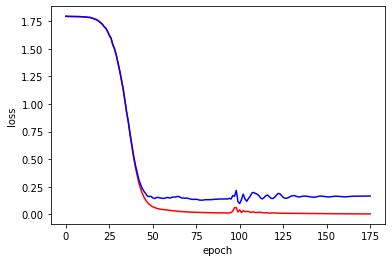

176
Fri Feb 10 12:41:56 2023
train loss: 0.0036081052385270596
test loss: 0.16614046692848206
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


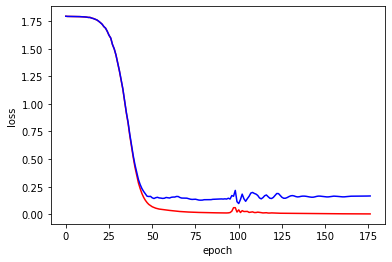

177
Fri Feb 10 12:41:56 2023
train loss: 0.00353986001573503
test loss: 0.16634926199913025
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


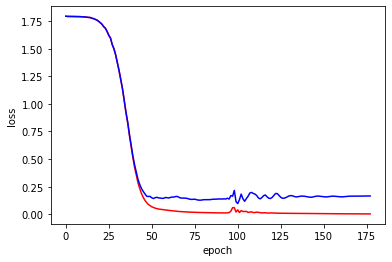

178
Fri Feb 10 12:41:57 2023
train loss: 0.003472083481028676
test loss: 0.16633924841880798
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


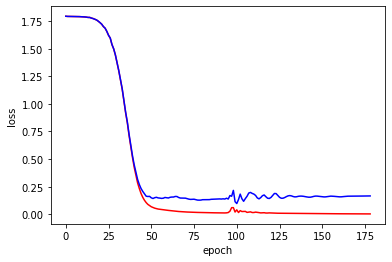

179
Fri Feb 10 12:41:57 2023
train loss: 0.0034412634558975697
test loss: 0.16594091057777405
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


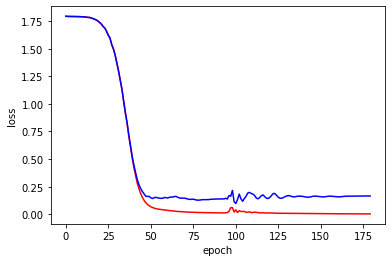

180
Fri Feb 10 12:41:57 2023
train loss: 0.0033834120258688927
test loss: 0.16529090702533722
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


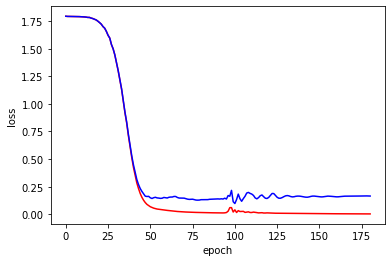

181
Fri Feb 10 12:41:57 2023
train loss: 0.0033032826613634825
test loss: 0.16488692164421082
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


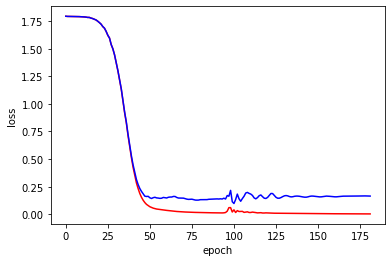

182
Fri Feb 10 12:41:57 2023
train loss: 0.0032811518758535385
test loss: 0.16437187790870667
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


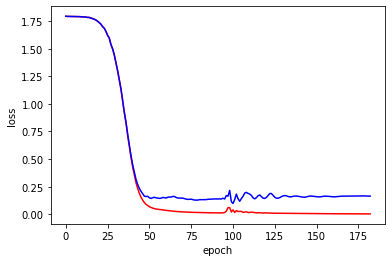

183
Fri Feb 10 12:41:58 2023
train loss: 0.0032293496187776327
test loss: 0.16348862648010254


In [ ]:
losses = []
losses_test = []

train_right_pre = []
test_right_pre = []

for epoch in range(300):
    
    print(epoch)
    print(time.asctime())
    
    net.eval()
    with torch.no_grad():
        pred_y_test = net(test_x)
        
        loss_test = loss_function(pred_y_test, test_y)
        
        losses_test.append(loss_test.item())
        
        test_right_pred = (m2(m1(pred_y_test
                                )
                             ).argmax(1) == test_y.argmax(1)).sum()
        
        test_right_pre.append(test_right_pred)
    
    net.train()
    pred_y = net(train_x)
    
    loss = loss_function(pred_y, train_y)

    losses.append(loss.item())
    
    train_right_pred = (m2(m1(pred_y
                                )
                             ).argmax(1) == train_y.argmax(1)).sum()
    train_right_pre.append(train_right_pred)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    plt.plot(losses, 'r')
    plt.plot(losses_test, 'b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.title('Train')

    print('train loss: ' + str(losses[-1]))
    print('test loss: ' + str(losses_test[-1]))
    print('predict right count in train: ' + str(train_right_pre[-1]))
    print('predict right count in test: ' + str(test_right_pre[-1]))
    
    plt.show()

#     torch.save(net.state_dict(), '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/no_dataloaderr_models/'
#                + str(epoch) 
#                +'_epoch_.pth')

In [ ]:
print(len(train_set))
print(len(test_set))

In [ ]:
min(losses_test)

In [ ]:
min(losses)

In [ ]:
losses_test.index(min(losses_test
                     )
                 )

In [ ]:
losses.index(min(losses
                )
            )

In [ ]:
max(train_right_pre)

In [ ]:
max(test_right_pre)

In [ ]:
train_right_pre.index(max(train_right_pre
                     )
                 )

In [ ]:
test_right_pre.index(max(test_right_pre
                     )
                 )

# get kernel and transform into DNA

In [ ]:
the_very_first_layer = net.conv1.weight

In [ ]:
the_very_first_layer[0][0].shape[1]

In [ ]:
the_very_first_layer[0][0][:, 0].argmax().item()

In [ ]:
the_very_first_layer.shape

In [ ]:
conv_d = {
    0: 'A',
    1: 'T',
    2: 'C',
    3: 'G'
}

d_kernels = {}

s = 0

for a_kernel in the_very_first_layer:
    the_only_channel = a_kernel[0]
    col_len = the_only_channel.shape[1]
    
    a_seq = ''
    for cols in range(col_len):
        base = the_only_channel[:, cols].argmax().item()
        
        a_seq = a_seq + conv_d[base]
        
    d_kernels[s] = a_seq
    
    s += 1

In [ ]:
d_kernels